<a href="https://colab.research.google.com/github/mohiteprathamesh1996/backorder-prediction/blob/main/backorder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Predict Inventory Products Back-Order to Manage Service Level 


#### Importing packages

In [2]:
import pandas as pd
pd.options.display.max_rows = 999
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error 

#### Load data

In [3]:
from google.colab import files

uploaded = files.upload()

df_product = pd.read_csv("Kaggle_Training_Dataset_v2.csv")

Saving Kaggle_Training_Dataset_v2.csv to Kaggle_Training_Dataset_v2 (2).csv


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_product.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [5]:
df_product = df_product[~df_product["went_on_backorder"].isna()].reset_index(drop=True)

#### Check and drop highly correlated features

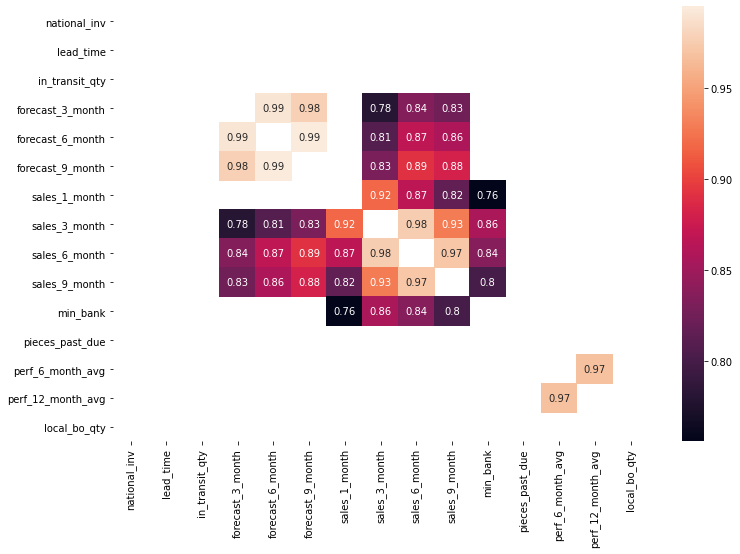

In [6]:
plt.rcParams["figure.figsize"] = (12, 8)

sns.heatmap(df_product.corr().abs()[(df_product.corr().abs()>0.75) & 
                                    (df_product.corr().abs()!=1)], annot=True)

plt.show()

#### Identify and segregate numerical and categorical features

In [7]:
numerical_features = [c for c in df_product.columns if df_product[c].dtypes==float or df_product[c].dtypes==int]

categorical_features = [c for c in df_product.columns if df_product[c].dtypes==object]

categorical_features.remove("sku")
categorical_features.remove("went_on_backorder")

#### Build pipeline
##### 1. Implement different column transformer for numerical and categorical features

In [8]:
# Numerical transformer
numerical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), 
                                        ("scaler", StandardScaler())])

# Categorical transformer
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant",
                                                                    fill_value="missing")),
                                          ("onehot", OneHotEncoder(handle_unknown="error", drop="first"))])

# Combined pre-processor
preprocessor = ColumnTransformer(transformers=[("NumericalTransformer", numerical_transformer, numerical_features), 
                                               ("CategoricalTransformer", categorical_transformer, categorical_features)])

##### 2. Pass the combined column transformer i.e. processor to the regression model

In [12]:
# Define pipeline for Logistic Regression classifier
lr_pipeline = Pipeline([("pipeline", preprocessor),
                        ("Logistic Regression", LogisticRegression())])

# Define pipeline for Decision Tree classifier
dtree_pipeline = Pipeline([("pipeline", preprocessor),
                           ("Decision Tree", DecisionTreeClassifier())])

# Define pipeline for Random Forest classifier
RF_pipeline = Pipeline([("pipeline", preprocessor),
                        ("Random Forest", RandomForestClassifier())])

# Define pipeline for KNN classifier
KNN_pipeline = Pipeline([("pipeline", preprocessor),
                         ("K-Nearest Neighbors", KNeighborsClassifier())])

# Define pipeline for Gradient boosting classifier
GBoost_pipeline = Pipeline([("pipeline", preprocessor),
                            ("Gradient Boosting", GradientBoostingClassifier())])


# Create list of all above pipelines
concat_pipelines = [lr_pipeline, dtree_pipeline, RF_pipeline]

#### Split training and test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_product[numerical_features+categorical_features],
                                                    df_product["went_on_backorder"].map({'Yes': 1, 'No': 0}),
                                                    test_size=0.20,
                                                    random_state=42)

#### Evaluating model performance

In [14]:
# Fit each model in the pipeline on the training data
for model in tqdm(concat_pipelines[:3]):
  model.fit(X_train, y_train)

# Best performance on test data
leaderboard = pd.DataFrame([(model.steps[1][0], 
               model.score(X_train, y_train), 
               model.score(X_test, y_test),
               model) for model in concat_pipelines], 
             columns=["Algorithm", "Training Accuracy", "Validation Accuracy","FittedModel"]).sort_values(by=["Validation Accuracy"], 
                                                                                  ascending=False).reset_index(drop=True).head()

leaderboard.head()

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
100%|██████████| 3/3 [06:18<00:00, 126.12s/it]


,Algorithm,Training Accuracy,Validation Accuracy,FittedModel
0,Random Forest,0.999593,0.994534,"(ColumnTransformer(n_jobs=None, remainder='dro..."
1,Logistic Regression,0.993392,0.992926,"(ColumnTransformer(n_jobs=None, remainder='dro..."
2,Decision Tree,0.999596,0.991625,"(ColumnTransformer(n_jobs=None, remainder='dro..."
